<a href="https://colab.research.google.com/github/9143nithinreddy/BigDataAnalytics/blob/main/skill-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

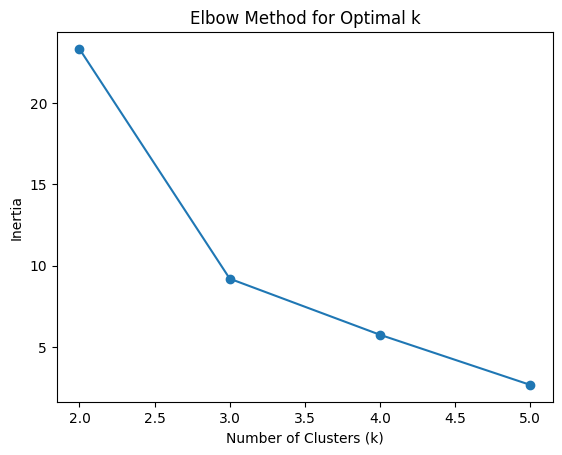

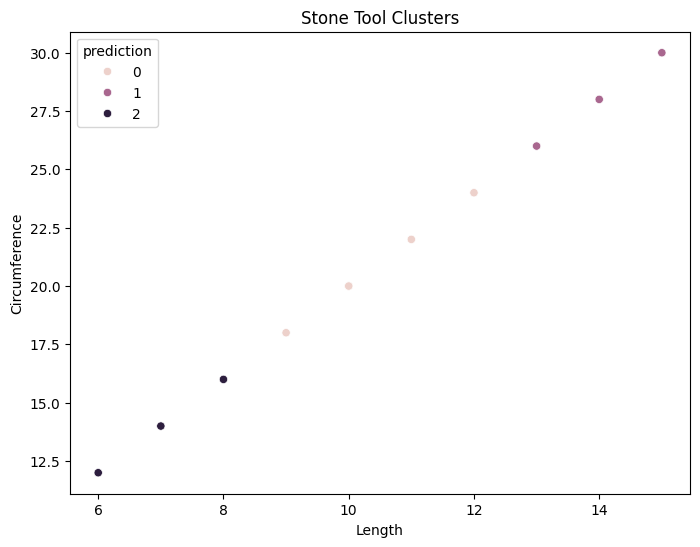

            mean_length  mean_circumference  mean_weight  count
prediction                                                     
0                  10.4                20.8         20.8      5
1                  14.0                28.0         28.0      3
2                   7.0                14.0         14.0      3


In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO  # For reading CSV from string

# Example data as a string (replace with your actual data loading)
data = """tool_id,length,circumference,weight,type
1,10,20,20,scraper
2,12,24,24,knife
3,8,16,16,scraper
4,15,30,30,axe
5,9,18,18,scraper
6,11,22,22,knife
7,13,26,26,axe
8,7,14,14,microlith
9,10,20,20,scraper
10,14,28,28,axe
11,6,12,12,microlith
"""

# Create a SparkSession
spark = SparkSession.builder.appName("StoneToolAnalysis").getOrCreate()

# Load the data from the string (simulates reading from a file)
df_pandas = pd.read_csv(StringIO(data))
stones_df_spark = spark.createDataFrame(df_pandas)

# Feature Engineering: Create a vector of features for clustering
assembler = VectorAssembler(inputCols=["length"], outputCol="features")
stones_df_features = assembler.transform(stones_df_spark)

# Determine optimal k (number of clusters) - Example using the Elbow Method
inertia = []
for k in range(2, 6):  # Try k from 2 to 5 (adjust the range as needed)
    kmeans = KMeans(k=k, seed=1)  # Seed for reproducibility
    model = kmeans.fit(stones_df_features)
    # Use model.summary.trainingCost instead of model.computeCost
    inertia.append(model.summary.trainingCost)

# Plot the Elbow Method graph
plt.plot(range(2, 6), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose the optimal k based on the Elbow Method plot (e.g., k=3)
optimal_k = 3  # Replace with the value you determine from the plot

# Perform K-means clustering with the optimal k
kmeans = KMeans(k=optimal_k, seed=1)
model = kmeans.fit(stones_df_features)
predictions = model.transform(stones_df_features)

# Convert Spark DataFrame to Pandas DataFrame for visualization
stones_df_pandas = predictions.toPandas()

# Visualize the clusters using Seaborn or Matplotlib
plt.figure(figsize=(8, 6))
sns.scatterplot(x="length", y="circumference", hue="prediction", data=stones_df_pandas)
plt.title("Stone Tool Clusters")
plt.xlabel("Length")
plt.ylabel("Circumference")
plt.show()

# Analyze the clusters (mean length, etc.)
cluster_summary = stones_df_pandas.groupby("prediction").agg(
    mean_length=("length", "mean"),
    mean_circumference=("circumference", "mean"),
    mean_weight=("weight", "mean"),
    count=("prediction", "size")
)
print(cluster_summary)

# Stop the SparkSession
spark.stop()